# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
#!pip -q install vit_pytorch linformer pandas sklearn scikit-learn ipywidgets

## Import Libraries

In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import lightning.pytorch as pl

from convert_pilimage_to_onehot import convert_pilimage_to_onehot
from model1 import Model1
from dataset1 import Dataset1

In [2]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1


In [3]:
# Training settings
batch_size = 64
epochs = 1
lr = 3e-5
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
#device = 'cpu'
device = 'mps'
#device = 'cuda'

## Load Data

In [6]:
os.makedirs('data', exist_ok=True)

In [8]:
with zipfile.ZipFile('tasks.zip') as tasks_zip:
    tasks_zip.extractall('data')

In [7]:
train_list = glob.glob('data/tasks/**/train/*.png', recursive=True)
test_list = glob.glob('data/tasks/**/test/*.png', recursive=True)

In [8]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 10069
Test Data: 1049


In [9]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

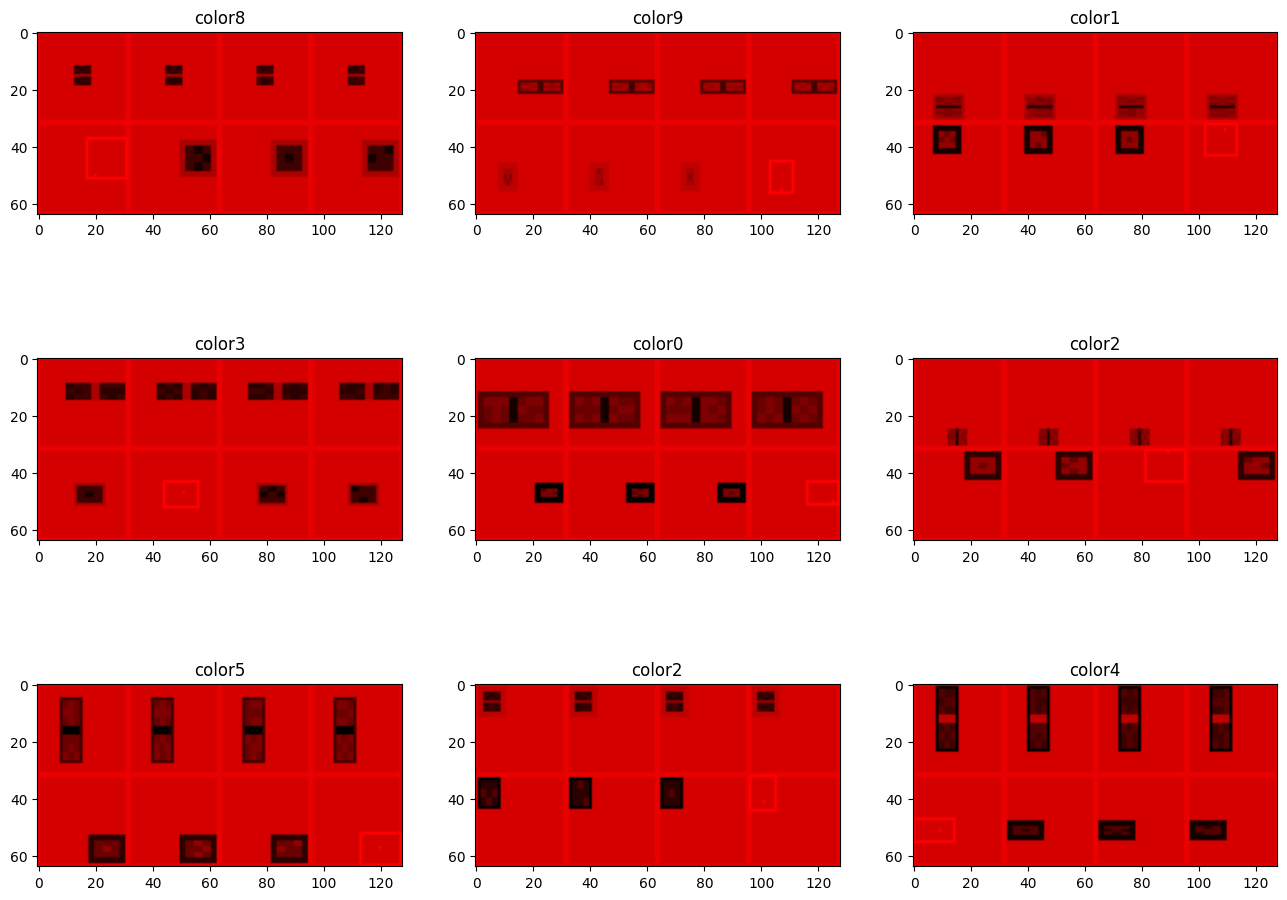

In [10]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [11]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [12]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 8055
Validation Data: 2014
Test Data: 1049


## Load Datasets

In [13]:
train_data = Dataset1(train_list)
valid_data = Dataset1(valid_list)
test_data = Dataset1(test_list)

In [14]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [15]:
print(len(train_data), len(train_loader))

8055 126


In [16]:
print(len(valid_data), len(valid_loader))

2014 32


## Efficient Attention

In [17]:
model = Model1()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1)
trainer.fit(model=model, train_dataloaders=train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ViT              | 4.2 M 
-----------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.762    Total estimated model params size (MB)
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [19]:
model = Model1.create_model().to(device)

### Training

In [20]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [21]:
checkpoint = torch.load('checkpoint2.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']

In [22]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:42<00:00,  2.95it/s]


Epoch : 1 - loss : 1.1598 - acc: 0.5503 - val_loss : 0.9200 - val_acc: 0.6111



In [23]:
# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [24]:
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

In [25]:
state = {
    'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, 'checkpoint2.pt')

In [26]:
import arc_json_model as ajm
from visualize import ajm_image_show
import export_task_to_image as etti
from pil_image_from_pixels import pil_image_from_pixels_with_red_palette
from simple_image import image_new, set_pixel, draw_rect, draw_box

ajm.Image.show = ajm_image_show

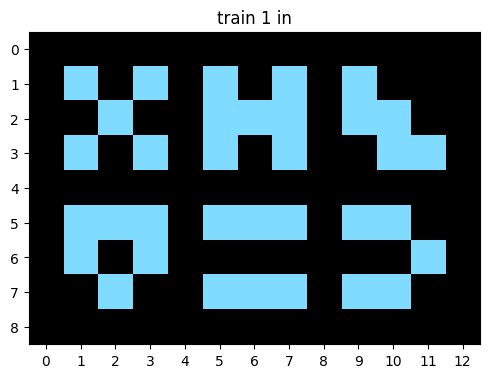

In [27]:
filename = 'testdata/1c0d0a4b.json'
#filename = 'testdata/c3202e5a.json'
#filename = 'testdata/0b148d64.json'
#filename = 'testdata/95a58926.json'
#filename = 'testdata/a59b95c0.json'
#filename = 'testdata/0520fde7.json'
#filename = 'testdata/e98196ab.json'
#filename = 'testdata/23581191.json'
#filename = 'testdata/281123b4.json'
#filename = 'testdata/3428a4f5.json'
#filename = 'testdata/48131b3c.json'
#filename = 'testdata/af902bf9.json'
#filename = 'testdata/cf98881b.json'
#filename = 'testdata/f2829549.json'
#filename = 'testdata/be94b721.json'
#filename = 'testdata/6773b310.json'
task = ajm.Task.load(filename)
image = task.pairs[1].input
image.show()

output size:  13 5


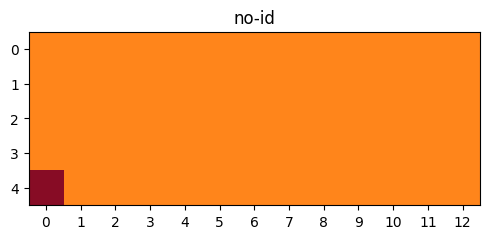

In [29]:
transform_image = Dataset1.create_transform()
exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)
for y in range(height):
    for x in range(width):
        pixels = exporter.image_with_mark(0, x, y)
        pil_image = pil_image_from_pixels_with_red_palette(pixels)

        img_transformed1 = transform_image(pil_image)
        img_transformed2 = convert_pilimage_to_onehot(img_transformed1)
        img_transformed3 = img_transformed2.transpose(2, 0, 1)
        tensor = torch.from_numpy(img_transformed3.astype(np.float32))
        
        #tensor = test_transforms(pil_image)
        tensor = tensor[None, :]
        #if x == 0 and y == 0:
            #pil_image.show()
        #if x == 2 and y == 2:
            #pil_image.show()
        #if x == 3 and y == 3:
            #pil_image.show()
            #print(tensor.shape)

        data = tensor.to(device)
        output = model(data)
        #print(output)
        output_tensor = output.cpu().detach()
        #print(output_tensor)
        output_value = output_tensor.argmax(dim=1)
        #output_value = output_tensor.argmax(dim=None)
        #print(output_value)
        #result_pixels
        set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()

In [125]:
class SingleImageDataset(Dataset):
    def __init__(self, single_image: Image, transform=None):
        self.single_image = single_image
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = self.single_image.copy()
        if self.transform:
            image = self.transform(image)
        label = 42
        return image, label

output size:  4 4
x, y 0 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 1 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 2 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 3 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 0 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 1 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 2 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 3 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 0 2
tensor([[ 0.1438,  0.

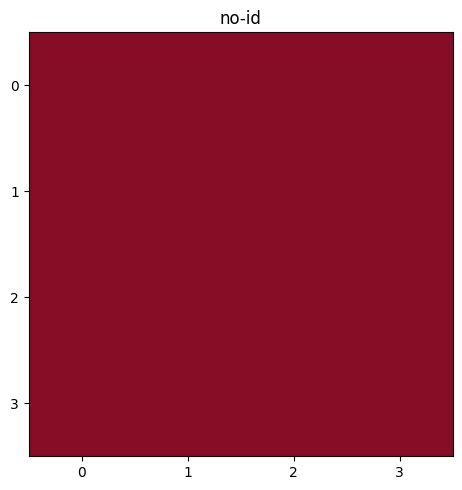

In [131]:

exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)
for y in range(height):
    for x in range(width):
        print("x, y", x, y)
        pixels = exporter.image_with_mark(0, x, y)
        pil_image = pil_image_from_pixels_with_red_palette(pixels)
        
        my_data = SingleImageDataset(pil_image, transform=test_transforms)
        my_loader = DataLoader(dataset = my_data, batch_size=batch_size, shuffle=True)
        for data, label in my_loader:
            #for data, label in tqdm(my_loader):
            #print(data.shape)
            data = data.to(device)

            output = model(data)
            #print(output)
            output_tensor = output.cpu().detach()
            print(output_tensor)
            output_value = output_tensor.argmax(dim=1)
            #print(output_value)
            #result_pixels
            set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()